### **Set Up**

Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from prettytable import PrettyTable
import os

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import re
import string
from tqdm.contrib.concurrent import process_map

/Users/youhorng/Desktop/data_science_projects/sentiment_analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/youhorng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Read Dataset

In [4]:
# Path to dataset 
path = "/Users/youhorng/.cache/kagglehub/datasets/snap/amazon-fine-food-reviews/versions/2"
filename = "Reviews.csv"

# Load the dataset
df = pd.read_csv(os.path.join(path, filename))
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### **Data Understanding**

Dataset Information

In [5]:
# Check for basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
# Shape of the dataset
print(f"Number of data points: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")


Number of data points: 568454
Number of columns: 10


In [7]:
# Check for missing values 
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [8]:
# Check for duplication
df.duplicated().sum()

0

In [9]:
# Check for descriptive statistics
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [10]:
# Descriptive statistics for categorical columns
df.describe(include=['object'])

,ProductId,UserId,ProfileName,Summary,Text
count,568454,568454,568428,568427,568454
unique,74258,256059,218415,295742,393579
top,B007JFMH8M,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",Delicious!,"This review will make me sound really stupid, ..."
freq,913,448,451,2462,199


**Inference**: Based on the information about the **Amazon Fine Food Reviews** dataset above, we have found that:

- There are 568,454 reviews in the dataset with 74,258 products. 

- There are 256,059 users who reviewed on the platform. 

- There are 10 features including the rating score from 1 to 5. 

- There is no duplication but with missing values in 2 columns:

    - There are 26 missing values in `ProfileName`.

    - There are 27 missing values in `Summary`.

Check Missing Values

In [11]:
# ProfileName missing values
df[df["ProfileName"].isnull()]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
10616,10617,B002DHN956,A1LSYR30XW7CFT,NaN,1,2,5,1291680000,Awesome,This is 72 for the price of like 24 at the gro...
25509,25510,B000LKZB4Y,A36BVYD0NT7Z0F,NaN,0,0,5,1314576000,These are the best mints and no aspartame or BHT,I was so shocked to find out that almost all g...
38874,38875,B000AYDGZ2,A36BVYD0NT7Z0F,NaN,2,3,1,1278374400,doesn't anyone care that they are putting BHT ...,I called Kellogg's to see why Special K red be...
47923,47924,B004SRH2B6,A2DEHJJIEAPPBF,NaN,0,0,5,1338940800,Great taste,Enjoy drinking this brand. Tastes as good as ...
49800,49801,B000CRHQN0,A2LYFY32LXQDON,NaN,0,0,2,1282608000,They were melted and the chocolate had turned ...,We love these bars but i won't order them ship...
67077,67078,B0006348H2,A2P0P67Y55SNOX,NaN,1,1,5,1314662400,Wheatgrass,Kitty seems to like this sprinkled on her food...
106550,106551,B001EQ5DG0,A1P500QXEG3IUZ,NaN,0,0,5,1326758400,Finally!,"You cannot find this in the stores anymore, it..."
121819,121820,B006N3I2SK,A34F9B57SYQ5XR,NaN,0,0,5,1335312000,Exactly what I ordered,"Very good coffee, very good price. It can be ..."
125452,125453,B001EO6ESS,A34F9B57SYQ5XR,NaN,0,0,5,1335312000,Exactly what I ordered,"Very good coffee, very good price. It can be ..."
137613,137614,B000CQE3HS,AGT3BYX5P9SLH,NaN,0,0,5,1324684800,awesome,i love them they are amazing I would eat them ...


**Inference**: According to the rows with `ProfileName` as NaN, we can see that there is no pattern here, and the `UserId` is still available. So, nothing extraordinary here. 

In [12]:
# Summary missing values
df[df["Summary"].isnull()]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
33958,33959,B00412W76S,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
40548,40549,B00020HHRW,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
101106,101107,B0014B0HWK,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
102979,102980,B000FVDWU4,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
117515,117516,B0016B7Z32,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
155712,155713,B0009VO58S,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
178290,178291,B00073IVAQ,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
198474,198475,B000FVBYCW,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
212691,212692,B00020HHAO,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
237565,237566,B000ELGPAO,A15AMT9T9A1309,Film-Friend,1,1,3,1328572800,NaN,This is a cool system only problem is that the...


**Inference**: Based on the dataframe above, we can see that everything except `ProductId` is the same. 

- This might be due to one product (like a protein bar) can have multiple variants (flavors, sizes).

- With each variant is given a different `ProductId`. 

- So, if a user writes a review for one variant, Amazon sometimes duplicates that reviews across all similar variants. 

Review Scores Distribution

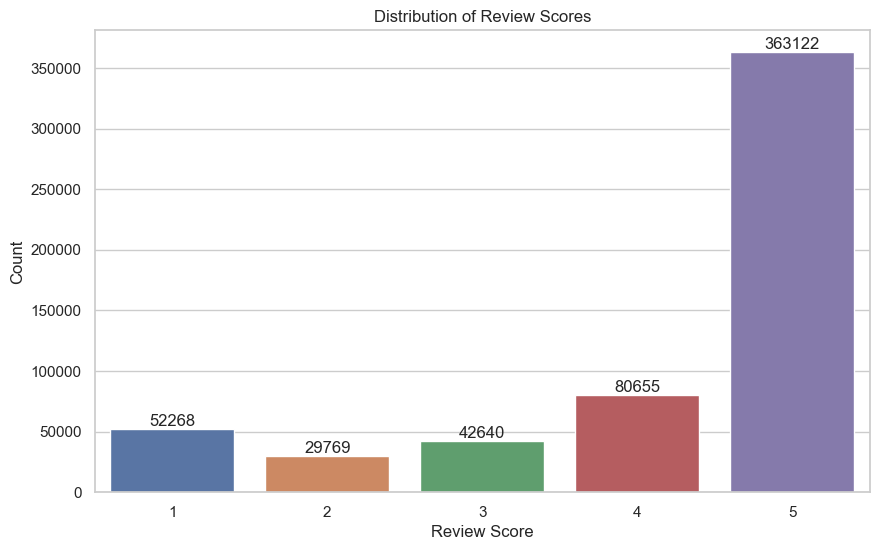

In [13]:
# Plot the distribution of review scores
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x="Score")

# Data label
for container in ax.containers:
    ax.bar_label(container)

plt.title("Distribution of Review Scores")
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.show()

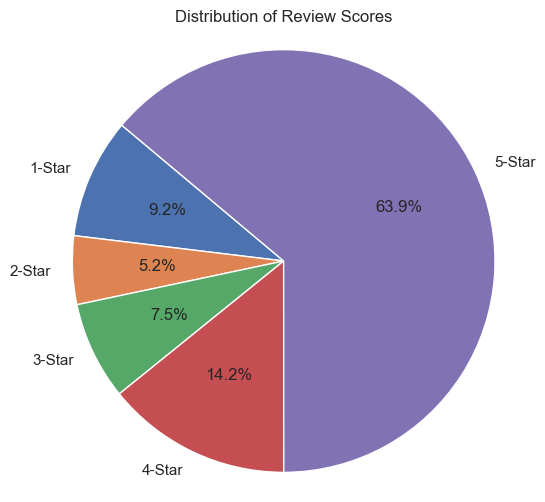

In [14]:
# Count score frequencies
sns.set_theme(style="whitegrid")
score_counts = df['Score'].value_counts().sort_index()

# Define labels and sizes
labels = [f'{score}-Star' for score in score_counts.index]
sizes = score_counts.values.astype(float)  

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Review Scores")
plt.axis("equal")  
plt.show()

**Inference**: According the distribution of the rating score above, we have found that:

- **63.9%** of the rating score is  5 star, indicating that most of the products got good review.

- **14.2%** of the rating score is 4 star, following by a 1 star with **9.2%**

### **Data Cleaning**

Check and Delete Duplicate Reviews

In [15]:
# Find the duplate reviews in specific subset
duplicated_reviews = df.duplicated(subset=["UserId", "Time", "Text"], keep="first")
count_duplicated_reviews = np.round(duplicated_reviews.value_counts() / len(df) * 100, 2)

# Create a table to display the results
table = PrettyTable()
table.field_names = ["", "Duplicated Reviews (%)"]
table.add_row(["Yes", count_duplicated_reviews[True]])
table.add_row(["No", count_duplicated_reviews[False]])
print(table)


+-----+------------------------+
|     | Duplicated Reviews (%) |
+-----+------------------------+
| Yes |         30.71          |
|  No |         69.29          |
+-----+------------------------+


**Inference**: We have found that nearly 31% of total reviews are duplicated across product variants. 

- They are the reviews that have the same user with the same text. 

- If we keep these duplications, it will introduce bias into the dataset as there is no meaningful pattern here.

In [16]:
# Remove the duplicated rows 
df = df[~duplicated_reviews]

# Check the shape of the dataset after removing duplicates
print(f"Number of data points after removing duplicates: {df.shape[0]}")

Number of data points after removing duplicates: 393892


Check 3 Rating Score

In [17]:
# Top 10 rows with 3 star rating
df[df["Score"]==3]["Text"].head(10)

45     This seems a little more wholesome than some o...
47     The flavors are good.  However, I do not see a...
49     This is the same stuff you can buy at the big ...
53     we're used to spicy foods down here in south t...
60     Watch your prices with this.  While the assort...
68     If you're impulsive like me, then $6 is ok. Do...
78     The taste was great, but the berries had melte...
83     While my dogs like all of the flavors that we ...
84     Awesome dog food. However, when given to my "B...
106    not what I was expecting in terms of the compa...
Name: Text, dtype: object

**Inference**: Through the text reviews above, we can see that we have a mix of negative reviews as well as neutral reviews.

- We cannot mark all the reviews with 3 star to negatives since they also contain neutral reviews. 

- However, we can choose to do Multi-class Classification with class Positive (4,5), Neutral (3), and Negative (1,2).

- But since some 3 star also contains negative reviews, we are going to focus on Binary Classification for now, which we only have 2 classes Postive and Negative.

- We are going to drop all the rows with 3 star rating.

In [18]:
# Exclue 3 star rating reviews
df = df[df["Score"]!=3]

In [19]:
# Check the shape after removal
print(f"Number of data points after removing 3-star reviews: {df.shape[0]}")

Number of data points after removing 3-star reviews: 364124


Check Inconsistent Reviews

In [20]:
# Helpfulness numerator values should not be higher than denominator
df[df["HelpfulnessNumerator"] > df["HelpfulnessDenominator"]]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


**Inference**: We can see that there are two reviews with the total number of reviews lower than the total number of reviews found helpful. 

- This means that we are going to drop these two as they are logically error.

In [21]:
# Remove rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
df = df[df["HelpfulnessNumerator"] <= df["HelpfulnessDenominator"]]

### **Feature Engineering**

In [22]:
# Check dataframe after initial cleaning 
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Create Helpfulness Percentage Feature

In [23]:
# Create the new Helpfulness column 
df["HelpfulnessPercentage"] = df[["HelpfulnessNumerator", "HelpfulnessDenominator"]].apply(
    lambda x: (x["HelpfulnessNumerator"] / x["HelpfulnessDenominator"]) * 100 if x["HelpfulnessDenominator"] > 0 else 0, axis=1
)

# Drop the HelpfulnessNumerator and HelpfulnessDenominator columns
df.drop(columns=["HelpfulnessNumerator", "HelpfulnessDenominator"], inplace=True)

# Check the dataframe
df.head()

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,HelpfulnessPercentage
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,100.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,100.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,100.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0.0


Helfulness Percentage Distribution

In [24]:
# Descriptive statistics for the new HelpfulnessPercentage column
df["HelpfulnessPercentage"].describe()

count    364122.000000
mean         42.286947
std          46.682364
min           0.000000
25%           0.000000
50%           0.000000
75%         100.000000
max         100.000000
Name: HelpfulnessPercentage, dtype: float64

/Users/youhorng/Desktop/data_science_projects/sentiment_analysis/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


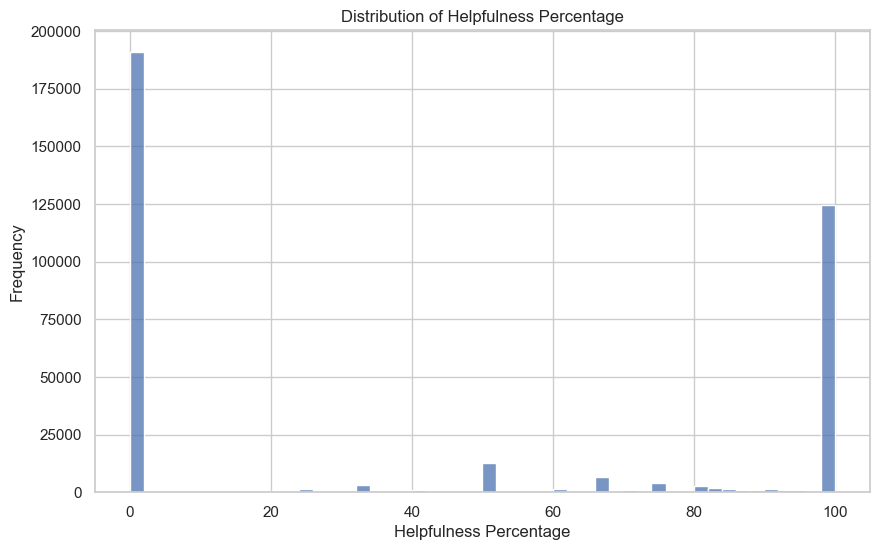

In [25]:
# Plot the distribution in Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="HelpfulnessPercentage", bins=50)
plt.title("Distribution of Helpfulness Percentage")
plt.xlabel("Helpfulness Percentage")
plt.ylabel("Frequency")
plt.show()

**Inference**: According to the distribution plot above, we have found that:

- **50%** of the whole data points have `HelpfulnessPercentage` of **0.0%**.

- The other **50%** has a range from above **0.0%** to **100%** with most of the points clustered here. 

- So, we can assume that, most of the reviews either are helpful and not available at all. 

Create Helpfulness Indicator Column

In [26]:
# Assign Helpfulness indicator 
def assign_helpfulness_indicator(helpfulness_percentage):
    if helpfulness_percentage >= 75:
        return "Useful"
    elif helpfulness_percentage >= 40:
        return "Intermediate"
    elif helpfulness_percentage > 0 and helpfulness_percentage < 40:
        return "Not Useful"
    else:
        return "Not Available"
    
# Apply the function to create a new column
df["HelpfulnessIndicator"] = df["HelpfulnessPercentage"].apply(assign_helpfulness_indicator)

# Drop the HelpfulnessPercentage column
df.drop(columns=["HelpfulnessPercentage"], inplace=True)

# Check the dataframe
df.head()

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,HelpfulnessIndicator
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Useful
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not Available
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Useful
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Useful
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Not Available


Check Helpfulness Indicator Distribution

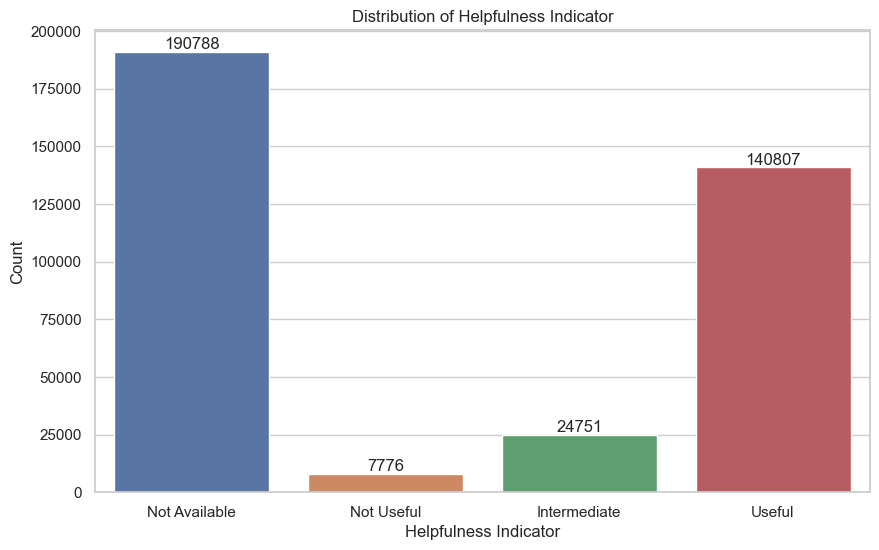

In [27]:
# Create countplot of each indicator
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x="HelpfulnessIndicator", 
                   order=["Not Available", "Not Useful", "Intermediate", "Useful"],)

# Add data label
for container in ax.containers:
    ax.bar_label(container)

plt.title("Distribution of Helpfulness Indicator")
plt.xlabel("Helpfulness Indicator")
plt.ylabel("Count")
plt.show()


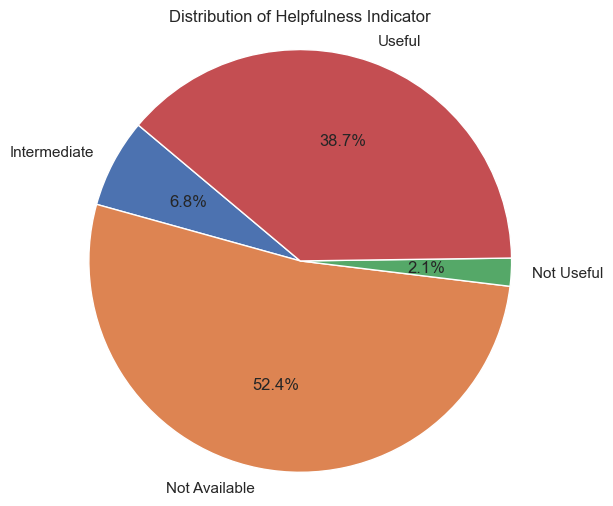

In [28]:
# Count score frequencies
sns.set_theme(style="whitegrid")
score_counts = df['HelpfulnessIndicator'].value_counts().sort_index()

# Define labels and sizes
labels = [f'{indicator}' for indicator in score_counts.index]
sizes = score_counts.values.astype(float)  

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Helpfulness Indicator")
plt.axis("equal")  
plt.show()

Assign Sentiment Class

In [29]:
# If rating score in [4,5], assign Positive
def assign_sentiment(score):
    if score in [4, 5]:
        return "Positive"
    else:
        return "Negative"
    
# Apply the function to create a new column
df["SentimentClass"] = df["Score"].apply(assign_sentiment)

# Check the dataframe
df.head()

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,HelpfulnessIndicator,SentimentClass
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Useful,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not Available,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Useful,Positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Useful,Negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Not Available,Positive


Check Distribution of Sentiment Class

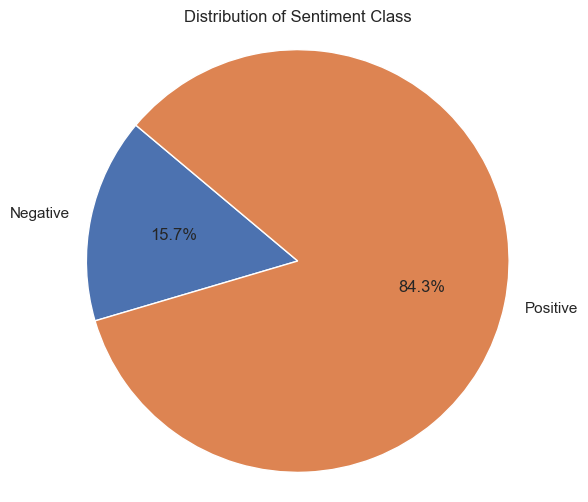

In [30]:
# Count score frequencies
sns.set_theme(style="whitegrid")
score_counts = df['SentimentClass'].value_counts().sort_index()

# Define labels and sizes
labels = [f'{sentiment}' for sentiment in score_counts.index]
sizes = score_counts.values.astype(float)  

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Sentiment Class")
plt.axis("equal")  
plt.show()

**Inference**: We have found that **Positive Review** is more common than **Negative Review** 

- The dataset contains imbalanced class.

Create Reviews Word Count Feature

In [31]:
# Check the length of reviews and assign new column
df["ReviewLength"] = df["Text"].apply(lambda x: len(x.split()))

# Check the dataframe
df.head()

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,HelpfulnessIndicator,SentimentClass,ReviewLength
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Useful,Positive,48
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not Available,Negative,31
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Useful,Positive,94
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Useful,Negative,41
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Not Available,Positive,27


In [32]:
# Check the distribution of review lengths
df["ReviewLength"].describe()   

count    364122.000000
mean         78.495463
std          76.090293
min           3.000000
25%          33.000000
50%          56.000000
75%          96.000000
max        2520.000000
Name: ReviewLength, dtype: float64

/Users/youhorng/Desktop/data_science_projects/sentiment_analysis/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


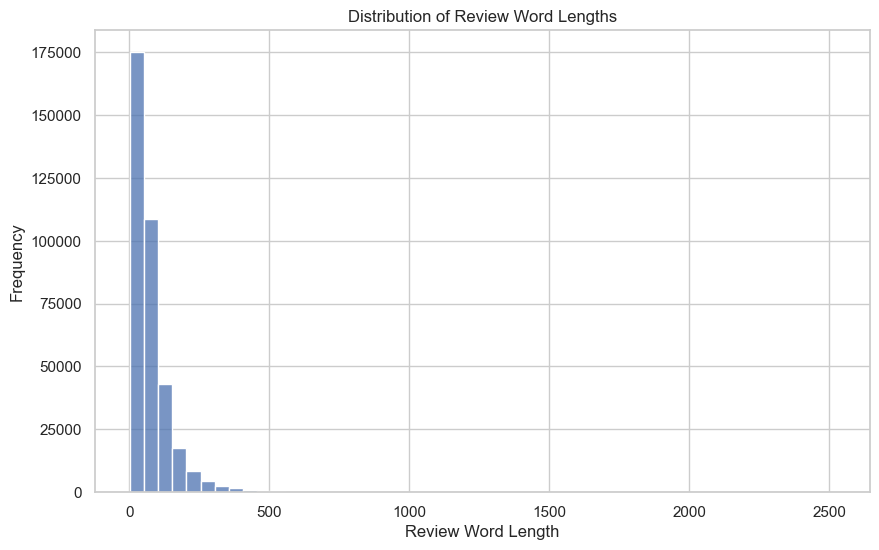

In [33]:
# Plot the distribution in Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="ReviewLength", bins=50)
plt.title("Distribution of Review Word Lengths")
plt.xlabel("Review Word Length")
plt.ylabel("Frequency")
plt.show()

**Inference**: According to the distribution plot above, we have found that:

- Most of the reviews have word legnths from 3 to 96, with outliers up to 2520.

### **Exploratory Data Analysis**

Check Distrbution of Useful and Non-Useful in Sentiment Class

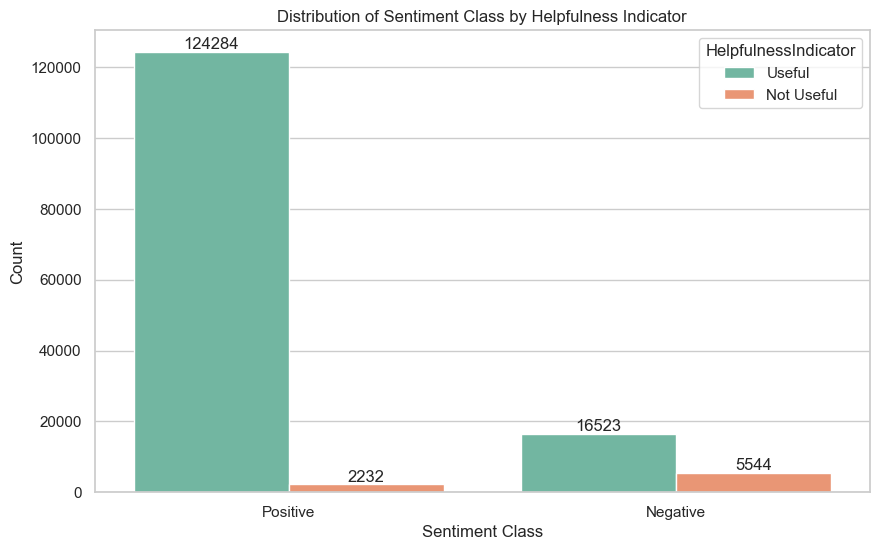

In [34]:
# Get only Useful and Not Useful reviews
df_temp = df[(df["HelpfulnessIndicator"] == "Useful") | (df["HelpfulnessIndicator"] == "Not Useful")]

# Create a count plot of each sentiment class
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_temp, x="SentimentClass", hue="HelpfulnessIndicator", 
              order=["Positive", "Negative"], palette="Set2")

# Add data label
for container in ax.containers:
    ax.bar_label(container)

plt.title("Distribution of Sentiment Class by Helpfulness Indicator")
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.show()

**Inference**: According to the graph above, we have found some interesting insights on the distribution of Sentiment Class by Helpfulness Indicator:

- For **Positive** class, we can see that mostly it contains **Useful** reviews, and only a small amount contains **Not Usefule** reviews.

    - This indicates that **Positive** Sentiment Class tends to have **Useful** reviews as well. 

- Meanwhile, for **Negative** class, we can see that the number of **Not Useful** reviews is double the the **Postive** class even though the total number of Negative class is far below the Positive Class. 

Check Review Length and Review Usefulness

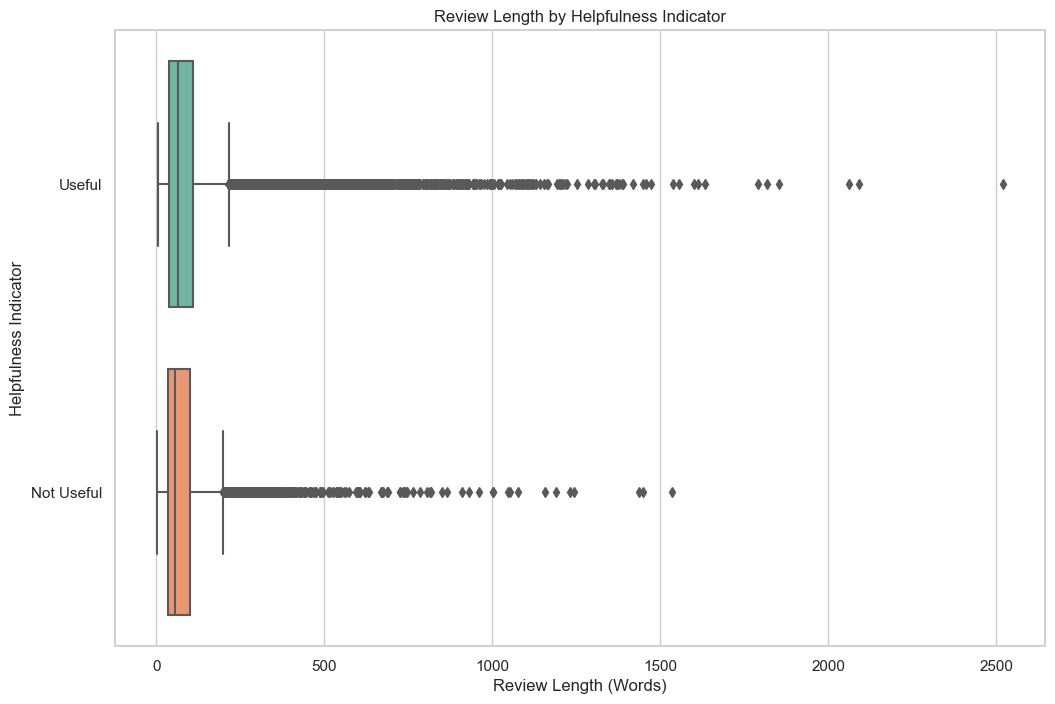

In [35]:
# Create boxplot of ReviewLength by Review Usefulness 
df_temp = df[(df["HelpfulnessIndicator"] == "Useful") | (df["HelpfulnessIndicator"] == "Not Useful")]

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_temp, x="ReviewLength", y="HelpfulnessIndicator", palette="Set2", orient="h")
plt.title("Review Length by Helpfulness Indicator")
plt.xlabel("Review Length (Words)")
plt.ylabel("Helpfulness Indicator")
plt.show()

In [36]:
# Check the desriptive statistics of ReviewLength by HelpfulnessIndicator
df_temp["ReviewLength"].groupby(df_temp["HelpfulnessIndicator"]).describe()

,count,mean,std,min,25%,50%,75%,max
HelpfulnessIndicator,,,,,,,,
Not Useful,7776.0,82.577289,92.375084,3.0,33.0,56.0,99.0,1535.0
Useful,140807.0,89.189976,86.472357,6.0,38.0,64.0,109.0,2520.0


**Inference**: Based on the boxplot and the descriptive table above, we have found that:

- **Useful** reviews have higher review word length than **Non Useful** reviews.

- This is true as usefule reviews tend to contain more words to be more informative. 

Check Review Length and Sentiment Class

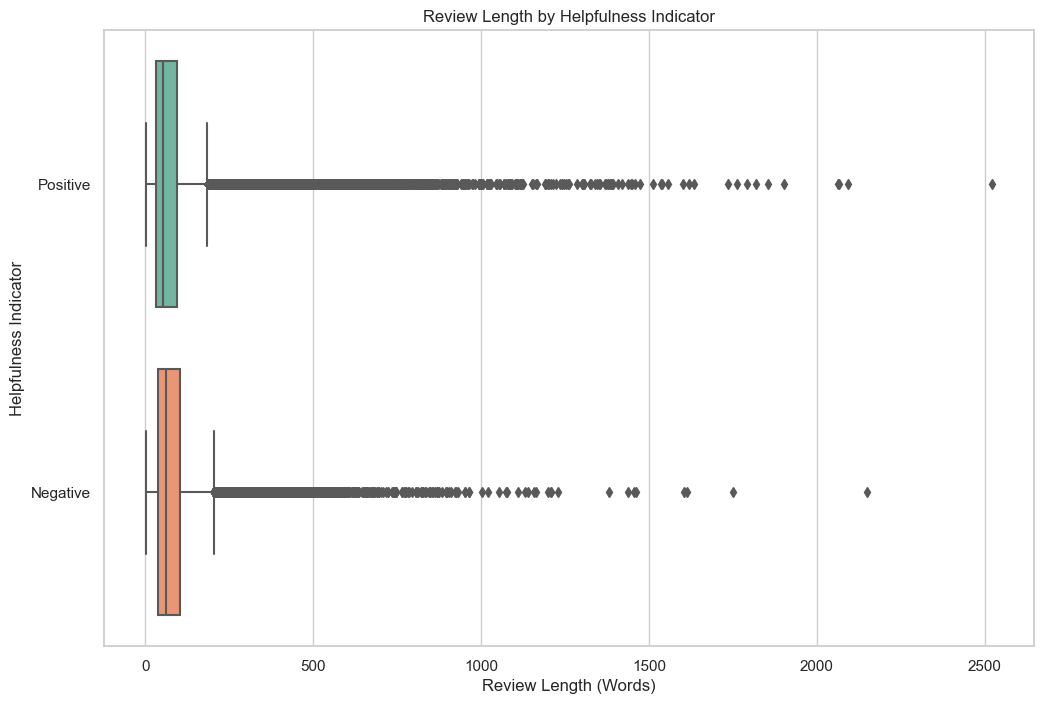

In [37]:
# Create boxplot of ReviewLength by Review Usefulness 
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x="ReviewLength", y="SentimentClass", palette="Set2", orient="h")
plt.title("Review Length by Helpfulness Indicator")
plt.xlabel("Review Length (Words)")
plt.ylabel("Helpfulness Indicator")
plt.show()

In [38]:
# Check the desriptive statistics of ReviewLength by Sentiment Class
df_temp["ReviewLength"].groupby(df_temp["SentimentClass"]).describe()

,count,mean,std,min,25%,50%,75%,max
SentimentClass,,,,,,,,
Negative,22067.0,91.990348,85.293480,3.0,41.0,68.0,113.0,1612.0
Positive,126516.0,88.295101,87.052755,5.0,37.0,62.0,108.0,2520.0


**Inference**: Based on the boxplot and the descriptive table above, we have found that:

- **Negative** reviews have higher review words thatn **Positive** reviews.


Check Occurance of Word

Total length of all reviews: 155828447 characters


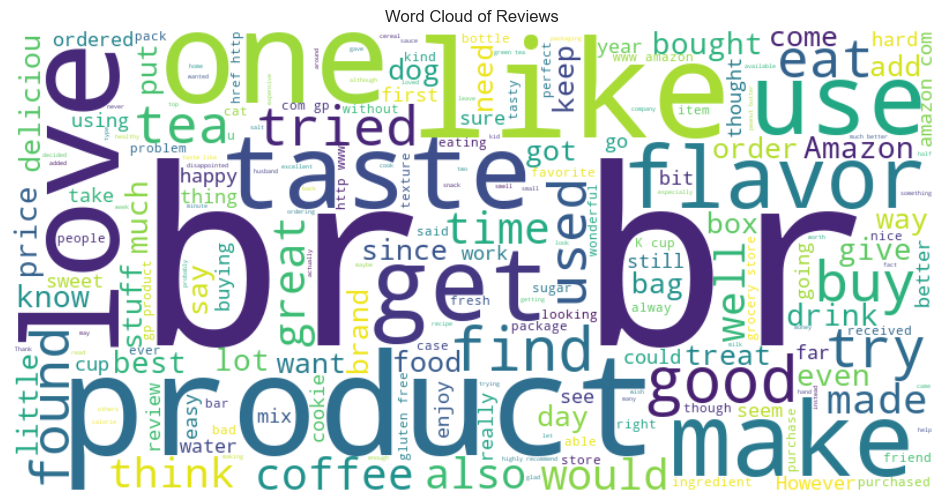

In [39]:
# Join all reviews together and find total length
all_reviews = " ".join(review for review in df["Text"])
print(f"Total length of all reviews: {len(all_reviews)} characters")

# Create stopword list
default_stopwords = set(stopwords.words("english"))

# Create a word cloud
wordcloud = WordCloud(stopwords=default_stopwords, background_color="white",
                      width=800, height=400, max_words=200).generate(all_reviews)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Reviews")
plt.show()

**Inference**: According to the graph above about the occurance of word in all reviews, we have found that:

- There is a high frequency of occurance of the word **br** in the reviews, indicating the HTML tags breaks: `<br> </br>`. So, we are going to handle this during the processing steps before training the data. 

- Apart from the HTML tags, we can also see frequent words like **product**, **love**, **like**, and **taste**.

Check Occurance of Word by Positive Class

Total length of all reviews: 129114833 characters


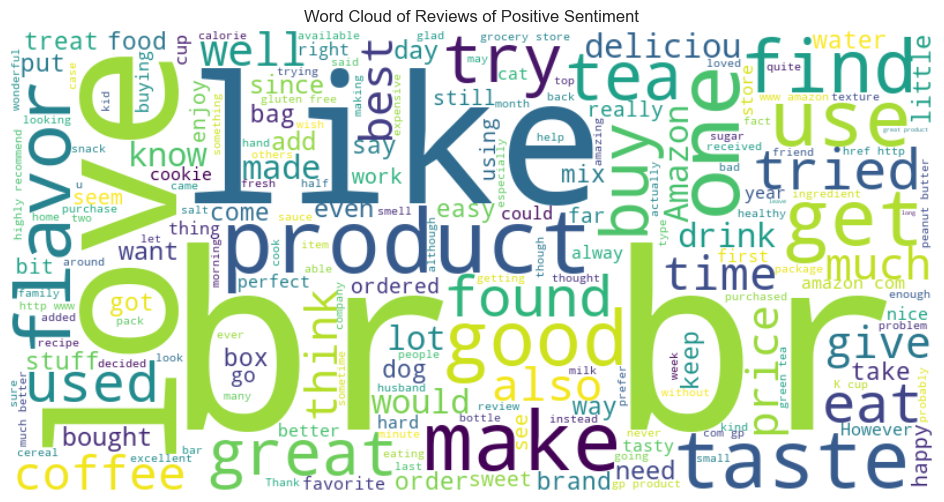

In [40]:
# Join all reviews together and find total length
df_temp = df[df["SentimentClass"] == "Positive"]
all_reviews = " ".join(review for review in df_temp["Text"])
print(f"Total length of all reviews: {len(all_reviews)} characters")

# Create stopword list
default_stopwords = set(stopwords.words("english"))

# Create a word cloud
wordcloud = WordCloud(stopwords=default_stopwords, background_color="white",
                      width=800, height=400, max_words=200).generate(all_reviews)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Reviews of Positive Sentiment")
plt.show()

**Inference**: Based on the graph above about the occurance of word by Positive Class, we have found that:

- **Positive** reviews usually have high frequent words like **like**, **love**, **great**, **good**. 

- These words are like patterns that we can use to make the prediction on the class sentiment.

Check Occurance of Word by Negative Class

Total length of all reviews: 26713613 characters


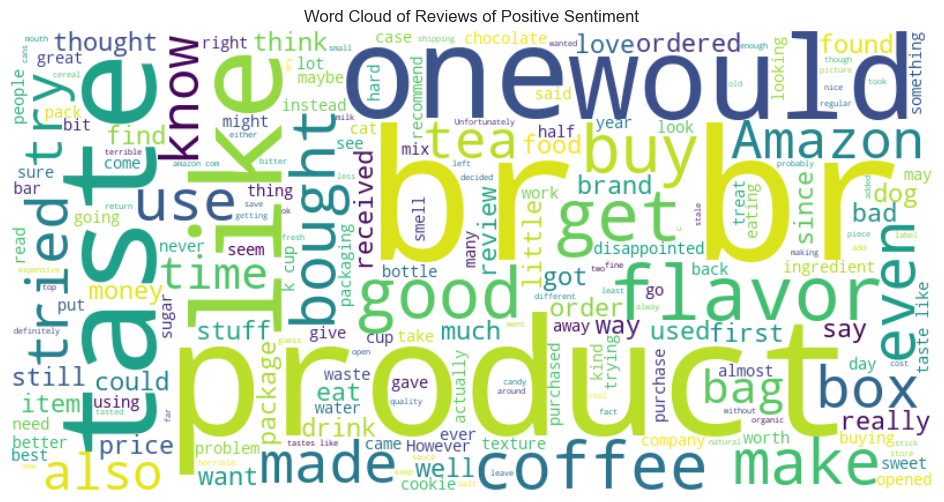

In [41]:
# Join all reviews together and find total length
df_temp = df[df["SentimentClass"] == "Negative"]
all_reviews = " ".join(review for review in df_temp["Text"])
print(f"Total length of all reviews: {len(all_reviews)} characters")

# Create stopword list
default_stopwords = set(stopwords.words("english"))

# Create a word cloud
wordcloud = WordCloud(stopwords=default_stopwords, background_color="white",
                      width=800, height=400, max_words=200).generate(all_reviews)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Reviews of Positive Sentiment")
plt.show()

**Inference**: Based on the occurance of words for Negative Class above, we have found that, 

- **Negative** reviews has **product** as the highest frequency word, with less on words like the **Positive** class.

- We can also see negative words like **bad**, **disappointed**, **hard**, **waste**.

**Exploratory Data Analysis Conclusion**

Based on the analysis and visualization above, these are the keys finding for the Amazon Fine Food Review dataset:

- **Positive** reviews are more common than **Negative** reviews, indicating a high imbalanced dataset.

- **Positive** reviews have shorter review words length than **Negative** reviews.

- **Useful** reviews have higher review word length than **Non Useful** reviews.

### **Data Preprocessing**

Lowercasing and Remove Punctuation

In [42]:
# Convert reviews to lowercase
df["Text"] = df["Text"].str.lower()

# Remove punctuation 
df["Text"] = df["Text"].apply(
    lambda x: x.translate(str.maketrans('', '', string.punctuation))
)

Remove HTML Tags

In [ ]:
# Find br tags in reviews
df[df["Text"].str.contains(r'\bbr\b', na=False, case=False)]["Text"]

10        i dont know if its the cactus or the tequila o...
18        twizzlers strawberry my childhood favorite can...
25        product received is as advertisedbr br a hrefh...
31        this offer is a great price and a great taste ...
32        mccanns instant oatmeal is great if you must h...
                                ...                        
568339    after the poptop ring came off i used some off...
568344    outch br i just received these french lady fin...
568425    this candy has a very good flavor it is quite ...
568433    i just bought this soup today at my local groc...
568446    i had ordered some of these a few months back ...
Name: Text, Length: 68314, dtype: object

**Inferences**: We have found about 68000 rows with 'br' inside the reviews for example,

- **Example**: ".. because of *itbr br* ... other *saucebr br* thank you for the personal incredible service"

- So, we would need to remove the standalone 'br' and also the attached 'br'

In [56]:
# Define a function remove the HTML Tags
def remove_html_tags(review):
    
    # Remove HTML tags like <br>, <a> and etc
    review = re.sub(r'<.*?>', '', review)

    # Remove standalone 'br' or attached to word like 'other saucebr br'
    review = re.sub(r"\bbr\b", "", review)             # standalone
    review = re.sub(r"br(?=\W|$)", "", review)         # 'br' at the end of a word or sentence
    review = re.sub(r"(?<=\w)br(?=\w)", "", review)    # 'br' in the middle of a word ('saucebr')
    review = re.sub(r"\s{2,}", " ", review).strip()
    
    return review


# Apply the function to the reivew as example
review = "<a href='sample.com'> <b> Click </b> here <br/> </a> want to use any other saucebr br it's amazing"
print(f"Before: {review}")
print(f"After: {remove_html_tags(review)}")

Before: <a href='sample.com'> <b> Click </b> here <br/> </a> want to use any other saucebr br it's amazing
After: Click here want to use any other sauce it's amazing


Remove URLs

In [ ]:
# Search for www and http links in reviews
df[df["Text"].str.contains(r'href', na=False, case=False)]["Text"].head()

21        i bought these for my husband who is currently...
25        product received is as advertisedbr br a hrefh...
39        i ordered this for my wife as it was reccomend...
348       these are delicious the chocolate is excellent...
369       green mountain nantucket blend kcups make a ve...
                                ...                        
567528    since i began following a hrefhttpwwwamazoncom...
567536    milk kefir grains arrived in a timely manner i...
568185    i recently tried some very expensive highly re...
568285    a hrefhttpwwwamazoncomgpproductb001izhzjanestl...
568310    if you are looking for a tasty snack look no f...
Name: Text, Length: 7139, dtype: object

**Inference**: There are around 7000 rows with link URLs in the rivews.

- **Example**: "... a hrefhttpwwwamazoncomgpproductb001gvisjmtwizzlers strawberry ..."

- So, we need to clean this out. 

In [63]:
# Define a function to remove links
def remove_links(review):

    # Remove malformed anchor patterns like: a hrefhttp..., hrefhttp..., ahrefhttp...
    review = re.sub(r"\ba\s*href\S*", "", review, flags=re.IGNORECASE)
    review = re.sub(r"\bhref\S*", "", review, flags=re.IGNORECASE)
    review = re.sub(r"\bahref\S*", "", review, flags=re.IGNORECASE)

    # Remove normal URLs: http(s), www
    review = re.sub(r"https?://\S+|www\.\S+", "", review)

    return review


# Apply the function to the reivew as example
review = """
This is an amazing product a hrefhttpwww.amazon.comgpproductb001gvisjm
Check out more at hrefhttpanotherlink.com or visit https://www.example.com for details.
Also available at www.shopnow.com!
"""
print(f"Before: {review}")
print(f"After: {remove_links(review)}")


Before: 
This is an amazing product a hrefhttpwww.amazon.comgpproductb001gvisjm
Check out more at hrefhttpanotherlink.com or visit https://www.example.com for details.
Also available at www.shopnow.com!

After: 
This is an amazing product 
Check out more at  or visit  for details.
Also available at 

